In [1]:

import torch 
import torchio as tio

import torchvision.transforms.functional as F
import torch.nn.functional as f
from torch.utils.data import Dataset

import os
import numpy as np

import SimpleITK as sitk
sitk.ProcessObject_SetGlobalWarningDisplay(False)


from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader

from matplotlib import pyplot as plt



In [18]:
def get_max_BB(D3_slice):
    masks = (D3_slice > 0).float()

    # boxes = ops.masks_to_boxes(binary_masks)
    boxes = []
    for mask in masks:
        # Get coordinates of non-zero pixels
        y, x = torch.where(mask)
        
        if len(y) == 0:  # Empty mask
            continue
            
        # Compute box coordinates
        box = [
            x.min(), y.min(),
            x.max(), y.max()
        ]
        
        boxes.append(box)
        
    boxes = torch.tensor(boxes)
    largest_box = torch.tensor([
        boxes[:, 0].min(),  # smallest x1
        boxes[:, 1].min(),  # smallest y1
        boxes[:, 2].max(),  # largest x2
        boxes[:, 3].max()   # largest y2
    ])
    return largest_box

def to_square_BB(BB):
    min_col, min_row,max_col, max_row = BB
    L = max_col - min_col
    W = max_row - min_row
    d = np.abs(L-W)
    eps_left = d//2 
    eps_right = d-eps_left
    if L>W : 
        min_row -= eps_left
        max_row += eps_right
    else : 
        min_col -= eps_left
        max_col += eps_right
    return [min_col, min_row, max_col, max_row]


def add_background_BB(suqare_BB,n_p = 10):
    min_col, min_row, max_col, max_row = suqare_BB

    min_col -= n_p
    min_row -= n_p
    max_row += n_p
    max_col += n_p
    BB_bg = [min_col, min_row, max_col, max_row]
    return BB_bg

def crop_img(D3_slice, img = None):
    """crops the image according to the BoundingBox extracted from the D3_slice (the segmentation)
    if img set to None, it crops automatically the segmentation given """

    BB = get_max_BB(D3_slice)
    BB = to_square_BB(BB)
    BB = add_background_BB(BB)
    min_col, min_row,max_col, max_row = BB

    if img == None:
        img = D3_slice

    croped = F.crop(img, min_row, min_col, max_row-min_row, max_col-min_col)
    return croped


def load_patient_gt(patient_PATH, modality) :
    """ Function that returns the patient heart-Segmentations if modality is specified as 'Seg', or 
    the patient heart-MRI if modality set to 'MRI'"""

    if (modality not in ['SEG', 'MRI']):
        assert("only 'SEG' and 'MRI' are accepted as modality types" )

    
    files = os.listdir(patient_PATH)
    image_files = [f for f in files if f.endswith('.nii.gz') and not f.endswith('_gt.nii.gz') and not f.endswith('4d.nii.gz')]
    gt_files = [f for f in files if f.endswith('_gt.nii.gz')]


    # Identify ED and ES frames
    frames = [f.split('_')[1].split('.')[0] for f in gt_files ]
    ed_frame = min(frames)
    es_frame = max(frames)

    # Load ground truth segmentations
    ed_gt = tio.LabelMap(os.path.join(patient_PATH, f"patient{patient_PATH[-3:]}_{ed_frame}_gt.nii.gz"))
    es_gt = tio.LabelMap(os.path.join(patient_PATH, f"patient{patient_PATH[-3:]}_{es_frame}_gt.nii.gz"))

    if(modality == 'SEG'):
        ed_gt_slices = crop_img(ed_gt.data.squeeze(0).permute(2,0,1)).flatten(start_dim = 0, end_dim=0) 
        es_gt_slices = crop_img(es_gt.data.squeeze(0).permute(2,0,1)).flatten(start_dim = 0, end_dim=0)
        return [tensor for tensor in ed_gt_slices] + [tensor for tensor in es_gt_slices]
    
    if(modality == 'MRI'):
        ed_mri = tio.LabelMap(os.path.join(patient_PATH, f"patient{patient_PATH[-3:]}_{ed_frame}.nii.gz"))
        es_mri = tio.LabelMap(os.path.join(patient_PATH, f"patient{patient_PATH[-3:]}_{es_frame}.nii.gz"))

        ed_mri_slices = crop_img(ed_gt.data.squeeze(0).permute(2,0,1), img = ed_mri.data.squeeze(0).permute(2,0,1) ).flatten(start_dim = 0, end_dim=0) 
        es_mri_slices = crop_img(es_gt.data.squeeze(0).permute(2,0,1), img = es_mri.data.squeeze(0).permute(2,0,1) ).flatten(start_dim = 0, end_dim=0)

        return [tensor.float() for tensor in ed_mri_slices] + [tensor.float() for tensor in es_mri_slices]



def load_dataset(Path, modality = 'SEG'):
    dataset = []
    patients = [patient for patient in os.listdir(Path) if os.path.isdir(os.path.join(Path, patient))]
    for patient in patients : 
        patient_gt = load_patient_gt(os.path.join(Path, patient), modality= modality) 
        dataset  += patient_gt
    return dataset





In [3]:
def visualize_batch(batch):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle('Batch elements', fontsize=20)


    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    plt.tight_layout()
    plt.show()


def visualize_batch_MRI(batch):
    """ visualize a batch if the dataset is of type MRI and not SEG 
    works only if batch size > 16 """

    batch_size = batch.shape[0]
    if batch_size < 16 : 
        assert('code works only if batch_size bigger than 16')

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Adjust figsize to accommodate more rows
    fig.suptitle('Batch elements', fontsize=20)


    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(4):

        
        axes[i,0].imshow(batch[i].squeeze(0), cmap = 'gray')
        axes[i,1].imshow(batch[i+4].squeeze(0), cmap = 'gray')
        axes[i,2].imshow(batch[i+8].squeeze(0), cmap = 'gray')
        axes[i,3].imshow(batch[i+12].squeeze(0), cmap = 'gray')
        # axes[i].axis('off')

    
    plt.tight_layout()
    plt.show()



In [4]:
#define the dataset

class ACDC_Dataset(Dataset):
    def __init__(self, data, transforms =None):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        item = item.unsqueeze(0)  # Shape: (1, H, W)

        if self.transforms:
            item = self.transforms(item)

        return item
    

class One_hot_Transform:
    def __init__(self, num_classes = 4):
        self.num_classes = num_classes
    
    def __call__(self, x):
        x = x.squeeze(0).long()
        one_hot_encoded = f.one_hot(x, num_classes=4)
        return one_hot_encoded.permute(2, 0, 1)    

class MinMaxNormalize:
    def __init__(self, min_value=0.0, max_value=1.0):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, image):
        min_img = image.min()
        max_img = image.max()

        # Apply Min-Max scaling to normalize the image
        normalized_image = (image - min_img) / (max_img - min_img)  # Scales to [0, 1]
        scaled_image = normalized_image * (self.max_value - self.min_value) + self.min_value  # Scale to [min_value, max_value]

        return scaled_image

class PercentileClip:
    def __init__(self, lower_percentile=1, upper_percentile=99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def __call__(self, image):
        # Flatten the image to compute percentiles
        flattened_image = image.view(-1)
        
        # Compute the percentile values
        lower_bound = torch.quantile(flattened_image, self.lower_percentile / 100.0)
        upper_bound = torch.quantile(flattened_image, self.upper_percentile / 100.0)
        
        # Clip the image values to the computed bounds
        clipped_image = torch.clamp(image, min=lower_bound.item(), max=upper_bound.item())
        
        return clipped_image

In [5]:

L = 128 # image size L=W
BATCH_SIZE = 16


In [19]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


In [20]:

train_dataset = load_dataset(train_set_path, modality='MRI')
test_dataset  = load_dataset(test_set_path, modality='MRI')


In [22]:

input_transforms_MRI = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    PercentileClip(lower_percentile=1, upper_percentile=99),
    MinMaxNormalize(min_value=0.0, max_value=1.0),

    ])

TrainDataset_MRI = ACDC_Dataset(data = train_dataset, transforms= input_transforms_MRI) 
TestDataset_MRI  = ACDC_Dataset(data = test_dataset, transforms= input_transforms_MRI)

TrainLoader_MRI  = DataLoader(TrainDataset_MRI, batch_size = BATCH_SIZE, shuffle = True)
TestLoader_MRI   = DataLoader(TestDataset_MRI , batch_size = BATCH_SIZE, shuffle = True)

(-0.5, 90.5, 90.5, -0.5)

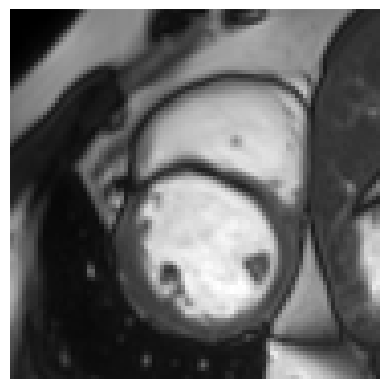

In [23]:
plt.imshow(train_dataset[3], cmap = 'gray')
plt.axis('off')

Batch of images shape: torch.Size([16, 1, 128, 128])
Batch of segmentations shape: torch.Size([16, 1, 128, 128])


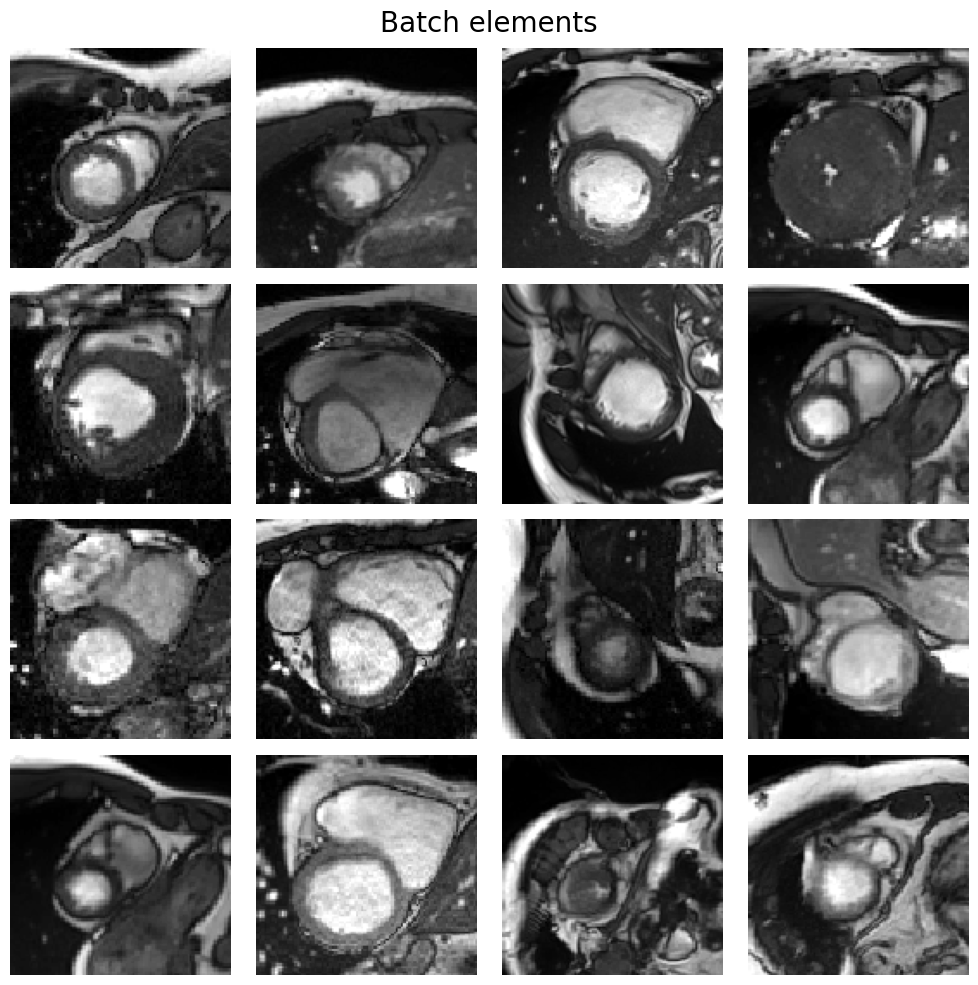

In [24]:
batch = next(iter(TrainLoader_MRI))


# Example usage:
# Visualize the first batch
print(f"Batch of images shape: {batch.shape}")
print(f"Batch of segmentations shape: {batch.shape}")
visualize_batch_MRI(batch)